# 大規模言語モデルのファインチューニング

# 1 環境の準備

In [1]:
!pip install transformers[ja,torch] datasets matplotlib japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 57.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 68.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [2]:
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

# 2 データセットの準備

In [4]:
from pprint import pprint
from datasets import load_dataset
import pandas as pd
from datasets import Dataset, ClassLabel

# Hugging Face Hub上のllm-book/wrime-sentimentのリポジトリからデータを読み込む
# original_train_dataset = load_dataset("llm-book/wrime-sentiment", split="train")
# valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")

# original_train_dataset = load_dataset("shunk031/JGLUE", name="MARC-ja", split="train")
# valid_dataset = load_dataset("shunk031/JGLUE", name="MARC-ja", split="validation")

# 学習データからN個のデータだけを抽出
# train_dataset = original_train_dataset.shuffle(seed=42).select([i for i in range(1000)])

# CSVファイルからデータを読み込む
original_train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('validation.csv')
train_dataset = Dataset.from_pandas(original_train_df)
valid_dataset = Dataset.from_pandas(valid_df)

# pprintで見やすく表示する
pprint(train_dataset[0])

{'label': 0,
 'sentence': '1月17日21時59分に乗用車の事故が発生。天気は晴れであった。路面は乾燥していた。事故が起こったのは道路上である。信号機は設置されていなかった。幅員が狭い道路である。現場はカーブで坂道になっている。'}


# 3. トークン化

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# モデル名を指定してトークナイザを読み込む
model_name = "cl-tohoku/bert-base-japanese-v3"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# トークナイザのクラス名を確認
print(type(tokenizer).__name__)

# テキストのトークン化
tokens = tokenizer.tokenize("これはテストです。")
print(tokens)

BertJapaneseTokenizer
['これ', 'は', 'テスト', 'です', '。']


In [6]:
# データのトークン化
from typing import Union
from transformers import BatchEncoding

def preprocess_text_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """文書分類の事例のテキストをトークナイズし、IDに変換"""
    encoded_example = tokenizer(example["sentence"], max_length=512)
    # モデルの入力引数である"labels"をキーとして格納する
    encoded_example["labels"] = example["label"]
    return encoded_example

encoded_train_dataset = train_dataset.map(
    preprocess_text_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_classification,
    remove_columns=valid_dataset.column_names,
)

# トークン化の確認
print(encoded_train_dataset[0])

Map:   0%|          | 0/1498 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/1314 [00:00<?, ? examples/s]

{'input_ids': [2, 32, 2806, 12576, 2698, 12668, 2734, 14765, 1010, 461, 22021, 5910, 464, 13491, 430, 12942, 385, 18834, 465, 25466, 457, 12514, 449, 385, 19326, 465, 18533, 441, 456, 422, 449, 385, 13491, 430, 15958, 449, 464, 465, 13105, 608, 457, 12485, 385, 15006, 3107, 465, 12740, 439, 494, 456, 422, 12581, 449, 385, 24836, 430, 19946, 13105, 457, 12485, 385, 15092, 465, 20559, 457, 1455, 7951, 461, 12493, 456, 12483, 385, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 0}


# 4 ミニバッチ構築

In [7]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# ミニバッチ結果の確認
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 75]),
 'input_ids': torch.Size([4, 75]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 75])}


# 5 モデルの準備

In [8]:
from transformers import AutoModelForSequenceClassification
from collections import Counter

# ファインチューニング済みモデルを読み込む
# model_name = "fine_tuned_model_directory"  # モデルが保存されたディレクトリパス


# データセットからラベルの一覧を取得
labels = [example["label"] for example in train_dataset]

# ラベルの数を計算
num_labels = len(set(labels))

label2id = {label: id for id, label in enumerate(range(num_labels))}
id2label = {id: label for id, label in enumerate(range(num_labels))}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    label2id=label2id,  # ラベル名からIDへの対応を指定
    id2label=id2label,  # IDからラベル名への対応を指定
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 6 訓練の実行

In [9]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_wrime",  # 結果の保存フォルダ
    per_device_train_batch_size=32,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    learning_rate=2e-5,  # 学習率
    lr_scheduler_type="linear",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=5,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=True,  # 自動混合精度演算の有効化
)

In [19]:
import numpy as np
import pandas as pd
from transformers import Trainer
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score

def compute_accuracy(eval_pred: tuple[np.ndarray, np.ndarray]) -> dict[str, float]:
    predictions, labels = eval_pred
    # predictionsは各ラベルについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='macro')  # または average='micro' など適切なオプションを選択してください
    recall = recall_score(labels, predictions, average='macro')  # または average='micro' など適切なオプションを選択してください

    return {"accuracy": accuracy, "precision": precision, "recall": recall}

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

# # ファインチューニング済みモデルを保存
model.save_pretrained("fine_tuned_model_directory")


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.409500,0.891279,0.516743,0.523184,0.513846
2,0.586900,0.725601,0.625571,0.651938,0.627416
3,0.576800,0.715172,0.615677,0.624682,0.614373
4,0.568700,0.670092,0.640791,0.640807,0.640817
5,0.574400,0.662703,0.640791,0.640769,0.640775


In [13]:

# # ファインチューニング済みモデルを保存
model.save_pretrained("fine_tuned_model_directory")

In [20]:
# 予測結果の取得
predictions = trainer.predict(encoded_train_dataset)

# is_correctを初期化
is_correct = []
# 正解したケースと誤ったケースの判定
is_correct = (predictions.predictions.argmax(axis=1) == predictions.label_ids)
correct_data = encoded_valid_dataset[is_correct]
incorrect_data = encoded_valid_dataset[~is_correct]

# original_train_dfとencoded_train_datasetを結合
combined_df = original_train_df.copy()
combined_df["input_ids"] = [encoded_input["input_ids"] for encoded_input in encoded_train_dataset]
combined_df["label"] = encoded_train_dataset["labels"]

correct_indices = []

# 正解したデータを抽出
correct_indices = [i for i, is_correct in enumerate(is_correct) if is_correct]
correct_data_df = combined_df.iloc[correct_indices]

# 誤ったデータを抽出
incorrect_indices = [i for i, is_correct in enumerate(is_correct) if not is_correct]
incorrect_data_df = combined_df.iloc[incorrect_indices]

# 'sentence'と'label'を抽出
correct_data_df = correct_data_df[["label","sentence"]]
incorrect_data_df = incorrect_data_df[["label","sentence"]]

# correct_data_df = correct_data_df.reset_index()
# correct_data_df = correct_data_df.rename(columns={"index": "id"})
# incorrect_data_df = incorrect_data_df.reset_index()
# incorrect_data_df = incorrect_data_df.rename(columns={"index": "id"})

# "train_correct.csv"と"train_false.csv"に格納
correct_data_df.to_csv("train_truecase.csv", index=False)
incorrect_data_df.to_csv("train_falsecase.csv", index=False)


# 7 精度検証

In [21]:
# 検証セットでモデルを評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 5.0,
 'eval_accuracy': 0.6407914764079148,
 'eval_loss': 0.6700916290283203,
 'eval_precision': 0.6408066814164417,
 'eval_recall': 0.6408171208930222,
 'eval_runtime': 2.1359,
 'eval_samples_per_second': 615.196,
 'eval_steps_per_second': 19.664}


# （参考） データセット統計の可視化

100%|██████████| 1000/1000 [00:00<00:00, 2218.00it/s]


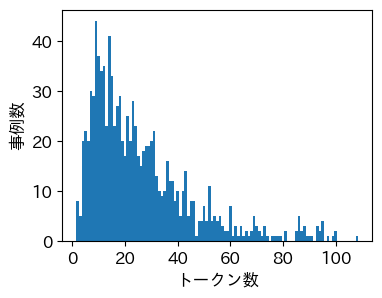

100%|██████████| 1608/1608 [00:00<00:00, 2056.91it/s]


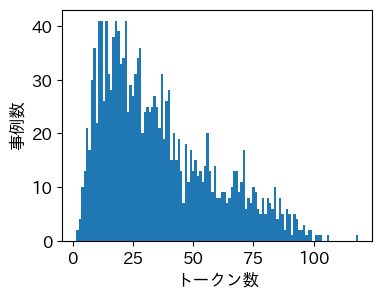

In [ ]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 12  # 文字サイズを大きくする

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    # データセット中のテキストの長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["sentence"]))
        length_counter[length] += 1
    # length_counterの値から棒グラフを描画する
    # グラフのサイズを設定
    plt.figure(figsize=(4, 3))  # 幅 8 インチ、高さ 6 インチ

    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()

visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

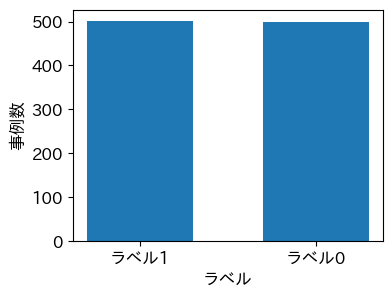

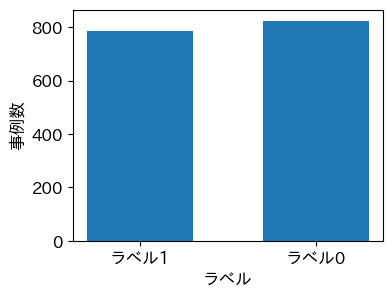

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

def visualize_labels(dataset):
    """データセット中のラベル分布をグラフとして描画"""
    # データセット中のラベルの数を数える
    label_counter = Counter()
    for data in dataset:
        label_id = data["label"]
        label_counter[label_id] += 1

    # ラベルIDをラベル名に変換するための辞書
    label_id_to_name = {0: "ラベル0", 1: "ラベル1"}

    # グラフのサイズを設定
    plt.figure(figsize=(4, 3))  # 幅 8 インチ、高さ 6 インチ

    # label_counterを棒グラフとして描画する
    label_names = [label_id_to_name[label_id] for label_id in label_counter.keys()]
    label_counts = list(label_counter.values())
    plt.bar(label_names, label_counts, width=0.6)
    plt.xlabel("ラベル")
    plt.ylabel("事例数")
    plt.show()

visualize_labels(train_dataset)
visualize_labels(valid_dataset)

In [ ]:
import pandas as pd
from datasets import load_dataset

# データセットを読み込む
original_train_dataset = load_dataset("llm-book/wrime-sentiment", split="train")
valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")

# データセットをPandas DataFrameに変換
original_train_df = pd.DataFrame(original_train_dataset)
valid_df = pd.DataFrame(valid_dataset)

#original_train_df[['sentence', 'label']].head(30)

#original_train_df[['sentence', 'label']].head(30)
print(len(original_train_df))
print(len(valid_df))

20149
1608


In [ ]:
import pandas as pd
from datasets import load_dataset

# データセットを読み込む
original_train_dataset = load_dataset("shunk031/JGLUE", name="MARC-ja", split="train")
valid_dataset = load_dataset("shunk031/JGLUE", name="MARC-ja", split="validation")

# データセットをPandas DataFrameに変換
original_train_df = pd.DataFrame(original_train_dataset)
valid_df = pd.DataFrame(valid_dataset)

#original_train_df[['sentence', 'label']].head(30)
print(len(original_train_df))
print(len(valid_df))


187528
5654


In [ ]:
original_train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('validation.csv')

print(len(original_train_df))
print(len(valid_df))

1498
1314
